## Tracer Study and Precipitation Response Analysis - Roaring Springs, Grand Canyon

### Objectives:


1. Use pulses of water as a tracer much the same way as a traditional flourescent dye.
    - Pulses of water include monsoon precipitation events that flash through the groundwater system and snowmelt events that are triggered by warming surface temperatures.
    - Determine response times of these pulses via sliding-window cross-correlation through the North Kaibab Plateau to Roaring Springs
    - See if methodology can be used to also determine travel paths of pulses.
        - PRISM dataset consists of daily precip and surface temp values measured at 136 locations/pixels on the Kaibab Plateau. Run sliding window correlations using for loop for each location with the hydrograph to see which locations correlate the best.  Exploratory and doesn't provide great resolution, but might be able to at least inform future dye traces.


2. Conduct Precipitation Reponse Analysis via SARIMAX model, Support Vector Machines, or Artificial Nueral Networks.  Maybe limited by data or models maybe too complicated.  If so, perform linear systems analysis or lumped parameter models.  Purpose is to simulate response of spring and to determine conduit-to-fracture/matrix coupling and what variables (EVT, soil moisture, saturation of system through previous precip events) play a role in the response of the spring.


In [140]:
pwd

'C:\\Users\\Nick\\Jupyter Notebooks\\prism_data_05.29.2020'

In [141]:
import glob as glob
import numpy as np
import functools as ft
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import os

%matplotlib inline

In [142]:
# import folium as fl
# from folium import plugins
# from scipy.ndimage import imread

In [143]:
from _plotly_future_ import v4_subplots
import plotly as pl
#import cufflinks as cf
#init_notebook_mode(connected=True)
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from plotly import __version__
print(__version__)

4.5.4


In [144]:
import plotly.offline as pyo

In [145]:
from pylab import rcParams  # this is just to change the default size of plots/figures in this jupyter notebook
rcParams['figure.figsize'] =12,7

# 1.0 Data importing and organization

### 1.1 Create dataframe of all PRISM precipitation csv files to be uploaded

In [146]:
files = pd.DataFrame(glob.glob('PRISM_ppt_tmean*.csv'))
print(files.count())
files.head(3)

0    145
dtype: int64


,0
0,PRISM_ppt_tmean_early_4km_20120101_20190801_36...
1,PRISM_ppt_tmean_early_4km_20120101_20190801_36...
2,PRISM_ppt_tmean_early_4km_20120101_20190801_36...


### 1.2 Import PRISM data from each csv emmitting the first 11 rows of metadata

In [147]:
#ONLY RUN THE LAST LINE ONCE OR ELSE IT WILL KEEP TRUNCATING THE FIRST 11 ROWS OF EACH CSV.

myfiles = glob.glob('PRISM_ppt_tmean*.csv')
for file in myfiles:
    lines = open(file).readlines()

#    open(file, 'w').writelines(lines[10:])

In [148]:
pd.read_csv(myfiles[8]).head(3)

,Date,ppt (inches),tmean (degrees F)
0,2012-01-01,0.0,38.5
1,2012-01-02,0.0,37.2
2,2012-01-03,0.0,38.2


### 1.3 Sort files base off indexing information in the last four characters in the file name

In [149]:
def last_4chars(x):
    return(x[-5:])

sortedfiles = sorted(myfiles, key = last_4chars, reverse = True)

### 1.4 Extract lat and long coordinates from each csv file name.

In [150]:
lat = pd.DataFrame(pd.DataFrame(sortedfiles)[0].str[44:51])
long = pd.DataFrame(files[0].str[52:61])

### 1.5 Create new dataframe where each file is tied to a location

In [151]:
files_w_loc = pd.concat([pd.DataFrame(sortedfiles),lat,long], axis=1)
files_w_loc.reset_index
files_w_loc.columns=['File_name','Latitude','Longitude']
files_w_loc.head(3)

,File_name,Latitude,Longitude
0,PRISM_ppt_tmean_early_4km_20120101_20190801_36...,36.1319,-111.9628
1,PRISM_ppt_tmean_early_4km_20120101_20190801_36...,36.1532,-111.9188
2,PRISM_ppt_tmean_early_4km_20120101_20190801_36...,36.1620,-112.0045


### 1.6 Import Roaring Springs shallow and deep site datasets to be used in correlations

##### RS Shallow Site - Pressure, Temp, Depth

In [152]:
RS_shallow_raw = pd.read_excel('RS_shallow.xlsx', index_col='Datetime', parse_dates=True)  

In [153]:
RS_shallow_raw.head(2)

,Pressure(psi),Temp(degC),Depth(ft)
Datetime,,,
2012-02-21 02:00:00,0.257,10.684,0.594
2012-02-21 02:15:00,0.261,10.683,0.603


In [154]:
type(RS_shallow_raw.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [155]:
RS_shallow_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265192 entries, 2012-02-21 02:00:00 to 2019-09-14 12:00:00
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Pressure(psi)  265181 non-null  float64
 1   Temp(degC)     265182 non-null  float64
 2   Depth(ft)      265183 non-null  float64
dtypes: float64(3)
memory usage: 8.1 MB


In [156]:
#Correct Time.  Prism data is + 10hrs off from RS Data
RS_shallow = RS_shallow_raw.reset_index(inplace=True)
RS_shallow = pd.DataFrame((RS_shallow_raw['Datetime'] + timedelta(hours=10)))
RS_shallow = pd.merge(RS_shallow_raw,RS_shallow)
RS_shallow.index = pd.to_datetime(RS_shallow['Datetime'], unit='s')
RS_shallow.head(5)

,Datetime,Pressure(psi),Temp(degC),Depth(ft)
Datetime,,,,
2012-02-21 12:00:00,2012-02-21 12:00:00,0.256,10.688,0.590
2012-02-21 12:15:00,2012-02-21 12:15:00,0.258,10.686,0.595
2012-02-21 12:30:00,2012-02-21 12:30:00,0.262,10.686,0.605
2012-02-21 12:45:00,2012-02-21 12:45:00,0.261,10.686,0.603
2012-02-21 13:00:00,2012-02-21 13:00:00,0.253,10.684,0.584


##### RS Deep Site - Discharge

In [157]:
RS_deep_raw = pd.read_excel('RS_LT500_Discharge_from_Rating_Curve.xlsx')#, index_col='Datetime', parse_dates=True)

In [158]:
RS_deep_raw.head(5)

,Datetime,Discharge ft^3/s
0,2015-02-07 13:00:00,5.764846
1,2015-02-07 13:15:00,5.759566
2,2015-02-07 13:30:00,5.774497
3,2015-02-07 13:45:00,5.643982
4,2015-02-07 14:00:00,5.656094


In [159]:
#RS_deep.dropna().head(3)

In [160]:
timedelta(hours=10)

datetime.timedelta(seconds=36000)

In [161]:
#Correct Time.  Prism data is - 10hrs off from RS Data
#RS_deep = RS_deep_raw.reset_index(inplace=True)


RS_deep = pd.DataFrame((RS_deep_raw['Datetime'] - timedelta(hours=10)))
RS_deep = pd.merge(RS_deep_raw,RS_deep)
RS_deep.index = pd.to_datetime(RS_deep['Datetime'], unit='s')
RS_deep.head(5)

,Datetime,Discharge ft^3/s
Datetime,,
2015-02-07 13:00:00,2015-02-07 13:00:00,5.764846
2015-02-07 13:15:00,2015-02-07 13:15:00,5.759566
2015-02-07 13:30:00,2015-02-07 13:30:00,5.774497
2015-02-07 13:45:00,2015-02-07 13:45:00,5.643982
2015-02-07 14:00:00,2015-02-07 14:00:00,5.656094


##### Resample Depth, Temp, Discharge to daily mean data after correcting for time difference between datasets

In [162]:
RS_shallow_daily= RS_shallow.resample(rule='D').mean()
RS_shallow_daily.head(3)

,Pressure(psi),Temp(degC),Depth(ft)
Datetime,,,
2012-02-21,0.256646,10.685833,0.592542
2012-02-22,0.256240,10.686865,0.591771
2012-02-23,0.257531,10.689417,0.594552


In [163]:
RS_deep_daily = RS_deep.resample(rule='D').mean()
RS_deep_daily.head(3)

,Discharge ft^3/s
Datetime,
2015-02-07,5.724304
2015-02-08,5.710864
2015-02-09,5.707920


#### RS shallow site corrected Temperature

In [164]:
Shallow_Temp = RS_shallow_daily[['Temp(degC)']].copy()
Shallow_Temp.head()

,Temp(degC)
Datetime,
2012-02-21,10.685833
2012-02-22,10.686865
2012-02-23,10.689417
2012-02-24,10.690240
2012-02-25,10.690417


#### RS shallow site corrected depth

In [165]:
#Depth
Shallow_Depth = RS_shallow_daily[['Depth(ft)']].copy()
Shallow_Depth.head()

,Depth(ft)
Datetime,
2012-02-21,0.592542
2012-02-22,0.591771
2012-02-23,0.594552
2012-02-24,0.594719
2012-02-25,0.593677


##### RS deep site corrected Discharge

In [166]:
Deep_Discharge = RS_deep_daily[['Discharge ft^3/s']]
Deep_Discharge.head()

,Discharge ft^3/s
Datetime,
2015-02-07,5.724304
2015-02-08,5.710864
2015-02-09,5.707920
2015-02-10,5.744168
2015-02-11,5.732691


### 1.7 Merge RS Shallow Site Temperature data with precip data of every PRISM csv

In [167]:
Shallow_Temp.reset_index(inplace=True)
mf_t = []  #mf_t = merged temp and precip files

for file in sortedfiles:
    csv=pd.read_csv(file)
    Shallow_Temp['Datetime']=Shallow_Temp['Datetime'].astype(str)#, inplace=True)
    mf_t.append(pd.DataFrame(csv.merge(Shallow_Temp,how='outer', left_on=csv.iloc[:,0], right_on=Shallow_Temp.iloc[:,0])))
    
mf_t[0].sample(10)

,key_0,Date,ppt (inches),tmean (degrees F),Datetime,Temp(degC)
1683,2016-08-10,2016-08-10,0.06,68.9,2016-08-10,10.962719
1794,2016-11-29,2016-11-29,0.05,22.2,2016-11-29,11.028167
2582,2019-01-26,2019-01-26,0.00,35.3,2019-01-26,11.092340
2048,2017-08-10,2017-08-10,0.00,69.7,2017-08-10,10.753094
2719,2019-06-12,2019-06-12,0.00,68.0,2019-06-12,9.779751
1445,2015-12-16,2015-12-16,0.00,16.7,2015-12-16,11.023469
1905,2017-03-20,2017-03-20,0.00,53.8,2017-03-20,9.203354
2121,2017-10-22,2017-10-22,0.00,46.7,2017-10-22,10.880271
559,2013-07-13,2013-07-13,0.01,68.8,2013-07-13,10.807083
756,2014-01-26,2014-01-26,0.00,41.6,2014-01-26,10.917073


### 1.8 Merge RS Shallow Site Depth data with precip data of every PRISM csv

In [168]:
Shallow_Depth.reset_index(inplace=True)
mf_d = []  #mf_d = merged depth and precip files

for file in sortedfiles:
    csv2=pd.read_csv(file)
    Shallow_Depth['Datetime']=Shallow_Depth['Datetime'].astype(str)
    mf_d.append(pd.DataFrame(csv2.merge(Shallow_Depth,how='outer', left_on=csv2.iloc[:,0], right_on=Shallow_Depth.iloc[:,0])))

mf_d[0].sample(20)

,key_0,Date,ppt (inches),tmean (degrees F),Datetime,Depth(ft)
1925,2017-04-09,2017-04-09,0.00,44.4,2017-04-09,3.393922
1127,2015-02-01,2015-02-01,0.00,35.7,2015-02-01,0.567608
133,2012-05-13,2012-05-13,0.00,60.6,2012-05-13,0.696229
1167,2015-03-13,2015-03-13,0.00,42.9,2015-03-13,0.578809
1817,2016-12-22,2016-12-22,0.58,40.4,2016-12-22,0.526521
95,2012-04-05,2012-04-05,0.00,47.9,2012-04-05,1.124719
1661,2016-07-19,2016-07-19,0.14,69.2,2016-07-19,0.525896
1683,2016-08-10,2016-08-10,0.06,68.9,2016-08-10,0.525938
2062,2017-08-24,2017-08-24,0.03,66.7,2017-08-24,0.589310
1867,2017-02-10,2017-02-10,0.00,51.1,2017-02-10,0.706760


### 1.9 Merge RS Deep Site Discharge data with precip data of every PRISM csv

In [169]:
Deep_Discharge.reset_index(inplace=True)
mf_discharge = []  #mf_discharge = merged discharge and precip files

for file in sortedfiles:
    csv2=pd.read_csv(file)
    Deep_Discharge['Datetime']=Deep_Discharge['Datetime'].astype(str)
    mf_discharge.append(pd.DataFrame(csv2.merge(Deep_Discharge,how='outer', left_on=csv2.iloc[:,0], right_on=Deep_Discharge.iloc[:,0])))

mf_discharge[0].sample(20)

,key_0,Date,ppt (inches),tmean (degrees F),Datetime,Discharge ft^3/s
2655,2019-04-09,2019-04-09,0.00,57.8,2019-04-09,52.285687
2721,2019-06-14,2019-06-14,0.00,70.3,2019-06-14,13.071113
1812,2016-12-17,2016-12-17,0.47,32.8,2016-12-17,5.802266
504,2013-05-19,2013-05-19,0.00,54.6,NaN,NaN
2029,2017-07-22,2017-07-22,0.10,68.5,2017-07-22,6.677972
1273,2015-06-27,2015-06-27,0.00,77.2,2015-06-27,5.630633
1106,2015-01-11,2015-01-11,0.08,35.8,NaN,NaN
2,2012-01-03,2012-01-03,0.00,39.6,NaN,NaN
1517,2016-02-26,2016-02-26,0.00,43.8,2016-02-26,8.489481
1112,2015-01-17,2015-01-17,0.00,39.9,NaN,NaN


### 1.95 Merge RS Deep Site Discharge data with Snow data

In [221]:
# Deep_Discharge.reset_index(inplace=True)
#Have to convert to something other than datetime object to merge
Deep_Discharge['Datetime']=Deep_Discharge['Datetime'].astype(str)
BA_Station['DATE']=BA_Station['DATE'].astype(str)
Snow_Data = BA_Station.merge(Deep_Discharge,how='outer', left_on='DATE', right_on='Datetime')


In [223]:
Snow_Data

,STATION,NAME,DATE,DAPR,MDPR,MDSF,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT03,WT04,WT05,WT06,WT11,Datetime,Discharge ft^3/s
0,USC00021001,"BRIGHT ANGEL RANGER STATION, AZ US",2010-01-01,NaN,NaN,NaN,0.0,0.0,41.0,26.0,1.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00021001,"BRIGHT ANGEL RANGER STATION, AZ US",2010-01-02,NaN,NaN,NaN,0.0,0.0,38.0,39.0,19.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00021001,"BRIGHT ANGEL RANGER STATION, AZ US",2010-01-03,NaN,NaN,NaN,0.0,0.0,38.0,42.0,14.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00021001,"BRIGHT ANGEL RANGER STATION, AZ US",2010-01-04,NaN,NaN,NaN,0.0,0.0,36.0,37.0,9.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00021001,"BRIGHT ANGEL RANGER STATION, AZ US",2010-01-05,NaN,NaN,NaN,0.0,0.0,35.0,38.0,14.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-25,5.819496
3694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-26,5.807398
3695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-27,5.869737
3696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-29,5.544936


### 1.9 Deal with the null values in RS Shallow Temp and Depth, as well as RS Deep Discharge

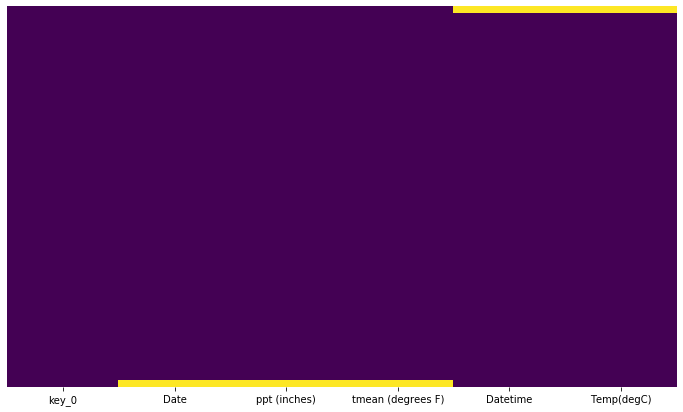

In [170]:
#Temp data
#Take a look at the missing values via a heatmap.  Yellow = nulls.
sns.heatmap(mf_t[0].isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [171]:
#remove the rows from each prism csv with Temp null values:

mf_t_noNA = []
for file in mf_t:
    #noNA = pd.read_csv(file)
    mf_t_noNA.append(file.dropna())
    
#Do the same for the Depth data
mf_d_noNA = []
for file in mf_d:
    #noNA = pd.read_csv(file)
    mf_d_noNA.append(file.dropna())
    
#Do the same for the discharge data from deep site
mf_discharge_noNA = []
for file in mf_discharge:
    #noNA = pd.read_csv(file)
    mf_discharge_noNA.append(file.dropna())
    


# 2.0 Visually explore KP data and RS data

### 2.1 Import daily mean precipitation, temperature, and evapotranspiration on Kaibab Plateau

In [172]:
PRISM_KPmean_precip = pd.read_csv('PRISM_KPmean_precip.csv')
PRISM_KPmean_temp = pd.read_csv('PRISM_KPmean_temp.csv')
MODIS_KPmean_EVT = pd.read_csv('KP_mean_EVT.csv')

### 2.1.2 Import snow depth data from Bright Angel Station and SWE from NRCS nrim snow course

In [192]:
BA_Station = pd.read_csv('BA_StationData.csv')#,index_col='DATE')

In [197]:
BA_Station.head(1)

,STATION,NAME,DATE,DAPR,MDPR,MDSF,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT03,WT04,WT05,WT06,WT11
0,USC00021001,"BRIGHT ANGEL RANGER STATION, AZ US",2010-01-01,NaN,NaN,NaN,0.0,0.0,41.0,26.0,1.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN


DAPR - Number of days included in the multiday precipitation total (MDPR)
SNOW - Snowfall
WT03 - Thunder
WT04 - Ice pellets, sleet, snow pellets, or small hail"
PRCP - Precipitation
WT05 - Hail (may include small hail)
TOBS - Temperature at the time of observation
WT06 - Glaze or rime
MDSF - Multiday snowfall total
SNWD - Snow depth
WT11 - High or damaging winds
WT01 - Fog, ice fog, or freezing fog (may include heavy fog)
TMAX - Maximum temperature
TMIN - Minimum temperature
MDPR - Multiday precipitation total (use with DAPR and DWPR, if available) 

### 2.2 Interative map of RS and KP data:

In [224]:
RS_shallow['Datetime']=pd.to_datetime(RS_shallow['Datetime'])
RS_deep['Datetime']=pd.to_datetime(RS_deep['Datetime'])
#RS_shallow['Datetime']=pd.to_datetime(RS_shallow['Datetime'])
#KPtmeans['Date']=pd.to_datetime(KPtmeans['Date'])
#KPpptmeans['Date']=pd.to_datetime(KPpptmeans['Date'])
PRISM_KPmean_temp['system:time_start']=pd.to_datetime(PRISM_KPmean_temp['system:time_start'])
PRISM_KPmean_precip['system:time_start']=pd.to_datetime(PRISM_KPmean_precip['system:time_start'])
MODIS_KPmean_EVT['system:time_start']=pd.to_datetime(MODIS_KPmean_EVT['system:time_start'])
BA_Station['DATE']=pd.to_datetime(BA_Station['DATE'])

fig = go.Figure()

#fig.add_trace(go.Bar(x=(KPpptmeans['Date']),y=((KPpptmeans['KP_ppt_mean(inches)'])*25.4), name='KPmean precip(mm)'))
#fig.add_trace(go.Scatter(x=(KPtmeans['Date']),y=KPtmeans['KP_tmean(degF)'], name='KP_tmean(degF)'))
fig.add_trace(go.Scatter(x=BA_Station['DATE'],y=BA_Station['TOBS'], name='Temperature recorded at BA Station (deg F)'))
fig.add_trace(go.Scatter(x=BA_Station['DATE'],y=BA_Station['PRCP'], name='Precipitation recorded at BA Station (mm)'))
fig.add_trace(go.Scatter(x=BA_Station['DATE'],y=BA_Station['SNWD'], name='Snow Depth recorded at BA Station (mm)'))
fig.add_trace(go.Scatter(x=BA_Station['DATE'],y=BA_Station['SNOW'], name='Snow Fall recorded at BA Station (mm)'))
fig.add_trace(go.Scatter(x=BA_Station['DATE'],y=BA_Station['MDSF'], name='Multiday Snowfall Total recorded at BA Station (mm)'))
fig.add_trace(go.Scatter(x=(PRISM_KPmean_temp['system:time_start']), y=(PRISM_KPmean_temp['tmean']), name='KPmean Temp (degC)', line=dict(color='orange', width=1))) #, dash='dash'
fig.add_trace(go.Scatter(x=(MODIS_KPmean_EVT['system:time_start']), y=(MODIS_KPmean_EVT['ET']/10), name='KPmean EVT (100g/m^2/8day)', line=dict(color='green', width=1)))
fig.add_trace(go.Scatter(x=(RS_shallow['Datetime']), y=(RS_shallow['Temp(degC)']), name='RS Shallow Site Temp(deg C)', line=dict(color='red', width=1.5)))
fig.add_trace(go.Scatter(x=(RS_shallow['Datetime']), y=(RS_shallow['Depth(ft)']*12), name='RS Shallow Site Depth (inches)',line=dict(color='darkblue', width=0.5)))
fig.add_trace(go.Scatter(x=(RS_deep['Datetime']), y=(RS_deep['Discharge ft^3/s']), name='RS Deep Site Discharge (ft^3/s)',line=dict(color='darkblue', width=0.5)))

fig.add_trace(go.Bar(x=(PRISM_KPmean_precip['system:time_start']), y=(PRISM_KPmean_precip['ppt']),  name='KPmean precip(mm)', marker_color='lightblue'))                                                  
#p.line(x=dTm['Datetime'], y=dTm['Temp(degC)'], color='orange',line_width=2, legend='RS Temp (Celcius)')
#p.line(x=dDm['Datetime'], y=(dDm['Depth(ft)']*12), color='green', line_width=2, legend = 'RS Depth (inches)')

# fig.show()
pl.offline.plot(fig, filename='RS_Datasets.html')

'RS_Datasets.html'

# 3.0 Create class object to analyze correlations between monsoon and rapid snowmelt events with precipitation and temperature on KP.

In [174]:
def crosscorr(datax, datay, lag=0):
    """ 
    Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    """
    return datax.corr(datay.shift(lag))


class event():
    """
    arguments include:
    flow_regime: can be either 'Monsoon' or 'Snowmelt' based on event type that is being correlated.  
        'Monsoon' correlates PRISM precipitation with the spring's depth and temp hydrograph data. 
        'Snowmelt' correlates PRSIM temperature with the spring's depth and temp hydrograph data.
    
    start_date = start date of range that is to be correlated
    stop_date = stop date of range that is to be correlated
    eventname = the name of the event to be included in plots
    """
    
    def __init__(self,flow_regime,start_date, stop_date, eventname):
        self.flow_regime = flow_regime
        self.start_date = start_date
        self.stop_date = stop_date
        self.eventname = eventname
        
    def best_lag(self, plot_type):
        """
        plot_type: can be either 'box' or 'bar.'  'bar' plots just the mean of the distribution.
        """
        #Filter the temp and depth data by the start and stop dates       
        temp_timefilter = [mf_t_noNA[i][(mf_t_noNA[i].Date >= self.start_date) & (mf_t_noNA[i].Date <= self.stop_date)] for i in list(range(0,136))]
        depth_timefilter = [mf_d_noNA[i][(mf_d_noNA[i].Date >= self.start_date) & (mf_d_noNA[i].Date <= self.stop_date)] for i in list(range(0,136))]


        if self.flow_regime == 'Monsoon':

            #run a correlation between the 136 csv precip files and RS temp for every lag up to 14 days.
            xcorr_t_vl = []       #vl = varying lag
            for i in list(range(0,136)):
                for l in list(range(0,14)):
                    xcorr_t_vl.append(crosscorr(temp_timefilter[i]['Temp(degC)'], temp_timefilter[i]['ppt (inches)'], lag = l))

            #xcorr_t_vl is returned as one massive array.  Split it into the 136 seperate files.
            temp_timefilter_vl_stats = pd.DataFrame(np.split(np.asarray(xcorr_t_vl),136))

            #run a correlation between the 136 csv precip files and RS depth for every lag up to 14 days.              
            xcorr_d_vl = []       
            for i in list(range(0,136)):
                for l in list(range(0,14)):
                    xcorr_d_vl.append(crosscorr(depth_timefilter[i]['Depth(ft)'], depth_timefilter[i]['ppt (inches)'], lag = l))

            #xcorr_d_vl is returned as one massive array.  Split it into the 136 seperate files.        
            depth_timefilter_vl_stats = pd.DataFrame(np.split(np.asarray(xcorr_d_vl),136))

            
            if plot_type == 'box':                
                #Plot the distribution of correlations for each lag via boxplots
                #Temp box plot
                data=[]
                for i in list(range(0,14)):                    
                    data.append(go.Box(y=(temp_timefilter_vl_stats[i]), fillcolor='orange', marker_color='orange', name=i))

                    layout = go.Layout(title=self.eventname, showlegend=False,
                                  xaxis={'title':'Lag'},
                                  yaxis={'title':'Pearson Correlation Coef'})

               #Depth box plot
                for i in list(range(0,14)):
                       
                    data.append(go.Box(y=(depth_timefilter_vl_stats[i]), fillcolor='blue', marker_color='blue', name=i))

                    layout = go.Layout(title=self.eventname,showlegend=False,
                                   xaxis={'title':'Lag'},
                                   yaxis={'title':'Pearson Correlation Coef'})

                fig=go.Figure(data=data, layout=layout)
                fig.show()
                
            elif plot_type == 'bar':
                depth_results = depth_timefilter_vl_stats.to_dict('list')  #depth_results = depth_timefilter_vl_stats.to_dict('list')
                fig, ax = plt.subplots()
                ax.boxplot(depth_results.values())
                ax.set_xticklabels(depth_results.keys())

#####################################

        elif self.flow_regime == 'Snowmelt':
            xcorr_t_vl = []       
            for i in list(range(0,136)):
                for l in list(range(0,14)):
                    xcorr_t_vl.append(crosscorr(temp_timefilter[i]['Temp(degC)'], temp_timefilter[i]['tmean (degrees F)'], lag = l))

            temp_timefilter_vl = np.asarray(xcorr_t_vl)
            temp_timefilter_vl_stats = pd.DataFrame(np.split(temp_timefilter_vl,136))        

            xcorr_d_vl = []       
            for i in list(range(0,136)):
                for l in list(range(0,14)):
                    xcorr_d_vl.append(crosscorr(depth_timefilter[i]['Depth(ft)'], depth_timefilter[i]['tmean (degrees F)'], lag = l))

            depth_timefilter_vl = np.asarray(xcorr_d_vl)
            depth_timefilter_vl_stats = pd.DataFrame(np.split(depth_timefilter_vl,136))

            if plot_type == 'box':
            #Plot the distribution of correlations for each lag via boxplots
            #Temp box plot
                data=[]
                for i in list(range(0,14)):
                    data.append(go.Box(y=(temp_timefilter_vl_stats[i]), fillcolor='orange', marker_color='orange', name=i))

                    layout = go.Layout(title=self.eventname, showlegend=False,
                                  xaxis={'title':'Lag'},
                                  yaxis={'title':'Pearson Correlation Coef'})

                #Depth box plot
                for i in list(range(0,14)):
                    data.append(go.Box(y=(depth_timefilter_vl_stats[i]), fillcolor='blue', marker_color='blue', name=i))

                    layout = go.Layout(title=self.eventname, showlegend=False,
                                  xaxis={'title':'Lag'},
                                  yaxis={'title':'Pearson Correlation Coef'})

                fig=go.Figure(data=data, layout=layout)
                fig.show()

            elif plot_type == 'bar':

                data=[go.Bar(y=(depth_timefilter_vl_stats.describe().transpose()['mean']), name=self.eventname), go.Bar(y=(temp_timefilter_vl_stats.describe().transpose()['mean']), name='RS Temp xcorr KP Precip')]
                layout = go.Layout(title=self.eventname,
                          xaxis={'title':'Lag'},
                          yaxis={'title':'Pearson Correlation Coef'})
                fig=go.Figure(data=data, layout=layout)
                fig.show()
  
  
    
    def contourmap(self, t_lag, d_lag, basemap):
        """
        t_lag = the selected temperature lag correlations to be plotted
        d_lag = the selected depth lag correlations to be plotted
        """

        temp_timefilter = [mf_t_noNA[i][(mf_t_noNA[i].Date >= self.start_date) & (mf_t_noNA[i].Date <= self.stop_date)] for i in list(range(0,136))]
        depth_timefilter = [mf_d_noNA[i][(mf_d_noNA[i].Date >= self.start_date) & (mf_d_noNA[i].Date <= self.stop_date)] for i in list(range(0,136))]


        if self.flow_regime == 'Monsoon':
            xcorr_event = []
            for i in list(range(0,136)):
                xcorr_event.append(crosscorr(temp_timefilter[i]['Temp(degC)'], temp_timefilter[i]['ppt (inches)'], t_lag))

            #Append correlation statistics to location data
            files_event = pd.concat([files_w_loc,pd.DataFrame(xcorr_event)], axis=1)
            files_event.columns = ['File_name','Latitude','Longitude', 'XCorrTemp']

            #Create interpolated map of correlation statistics
            files_event.dropna(inplace=True)
            lon_t = np.asarray(list(map(float, files_event['Longitude'])))
            lat_t = np.asarray(list(map(float, files_event['Latitude'])))
            corr_t = np.asarray(list(map(float, files_event['XCorrTemp'])))


            xcorr_event = []
            for i in list(range(0,136)):
                xcorr_event.append(crosscorr(depth_timefilter[i]['Depth(ft)'], depth_timefilter[i]['ppt (inches)'], d_lag))

            files_event = pd.concat([files_w_loc,pd.DataFrame(xcorr_event)], axis=1)
            files_event.columns = ['File_name','Latitude','Longitude', 'XCorrDepth']
            files_event.head(3)

            files_event.dropna(inplace=True)
            lon_d = np.asarray(list(map(float, files_event['Longitude'])))
            lat_d = np.asarray(list(map(float, files_event['Latitude'])))
            corr_d = np.asarray(list(map(float, files_event['XCorrDepth'])))

            

            if basemap == True:
                m1 = fl.Map(location=[36.42,-112.2], tiles = 'Stamen Terrain')

                temp = plt.tricontourf(lon_t,lat_t, corr_t,10,cmap='coolwarm')
                plt.savefig('temp')
                data = plt.imread('temp.png')
                t_event = fl.raster_layers.ImageOverlay(data, opacity=0.8, \
                        bounds =[[36.019, -111.8], [36.8594, -112.9]],\
                        attr = 'Temp Correlation')
                #add a name to the layer
                t_event.layer_name = 'Temp Correlation'
                # Overlay the image
                m1.add_child(t_event)
                # add the layer control

                depth = plt.tricontourf(lon_d,lat_d, corr_d,10,cmap='coolwarm')
                plt.savefig('depth')
                data2 = plt.imread('depth.png')
                d_event = fl.raster_layers.ImageOverlay(data2, opacity=0.8, \
                        bounds =[[36.019, -111.8], [36.8594, -112.9]],\
                        attr = 'Depth Correlation')
                #add a name to the layer
                d_event.layer_name = 'Depth Correlation'
                # Overlay the image
                m1.add_child(d_event)

                fl.LayerControl().add_to(m1)

                return m1
          
            elif basemap == False:
                fig, (ax1, ax2) = plt.subplots(1,2)
                ax1.tricontourf(lon_t,lat_t, corr_t,10,cmap='coolwarm')
                #fig.colorbar(ax=ax1)
                ax2.tricontourf(lon_d,lat_d, corr_d,10,cmap='coolwarm')
                #fig.colorbar(ax=ax2)
                #fig.savefig('ax1')
                #ax2.savefig('ax2')    
                       
            
            
        elif self.flow_regime=='Snowmelt':

            xcorr_event = []
            for i in list(range(0,136)):
                xcorr_event.append(crosscorr(temp_timefilter[i]['Temp(degC)'], temp_timefilter[i]['tmean (degrees F)'], t_lag))

            files_event = pd.concat([files_w_loc,pd.DataFrame(xcorr_event)], axis=1)
            files_event.columns = ['File_name','Latitude','Longitude', 'XCorrTemp']
            files_event.head(3)

            files_event.dropna(inplace=True)
            lon_t = np.asarray(list(map(float, files_event['Longitude'])))
            lat_t = np.asarray(list(map(float,files_event['Latitude'])))
            corr_t = np.asarray(list(map(float,files_event['XCorrTemp'])))


            xcorr_event = []
            for i in list(range(0,136)):
                xcorr_event.append(crosscorr(depth_timefilter[i]['Depth(ft)'], depth_timefilter[i]['tmean (degrees F)'], d_lag))

            files_event = pd.concat([files_w_loc,pd.DataFrame(xcorr_event)], axis=1)
            files_event.columns = ['File_name','Latitude','Longitude', 'XCorrDepth']
            files_event.head(3)

            files_event.dropna(inplace=True)
            lon_d = np.asarray(list(map(float, files_event['Longitude'])))
            lat_d = np.asarray(list(map(float,files_event['Latitude'])))
            corr_d = np.asarray(list(map(float,files_event['XCorrDepth'])))


            if basemap == True:
                
                m1 = fl.Map(location=[36.42,-112.2], tiles = 'Stamen Terrain')

                temp = plt.tricontourf(lon_t,lat_t, corr_t,10,cmap='coolwarm')
                plt.savefig('temp')
                data = plt.imread('temp.png')
                t_event = fl.raster_layers.ImageOverlay(data, opacity=0.8, \
                        bounds =[[36.019, -111.8], [36.8594, -112.9]],\
                        attr = 'Temp Correlation')
                #add a name to the layer
                t_event.layer_name = 'Temp Correlation'
                # Overlay the image
                m1.add_child(t_event)
                # add the layer control

                depth = plt.tricontourf(lon_d,lat_d, corr_d,10,cmap='coolwarm')
                plt.savefig('depth')
                data2 = plt.imread('depth.png')
                d_event = fl.raster_layers.ImageOverlay(data2, opacity=0.8, \
                        bounds =[[36.019, -111.8], [36.8594, -112.9]],\
                        attr = 'Depth Correlation')
                #add a name to the layer
                d_event.layer_name = 'Depth Correlation'
                # Overlay the image
                m1.add_child(d_event)

                fl.LayerControl().add_to(m1)

                return m1
            
            elif basemap == False:
                fig, (ax1, ax2) = plt.subplots(1,2)
                ax1.tricontourf(lon_t,lat_t, corr_t,10,cmap='coolwarm')
                #ax1.colorbar()
                ax2.tricontourf(lon_d,lat_d, corr_d,10,cmap='coolwarm')
                #ax2.colorbar()
            
            #plt.savefig(fname=self.eventname,format='tiff')
            #src_ds = gdal.Open('eventname.tiff')

# 3.1 Examine monsoon and snowmelt events to determine travel times and to hint at locations of infiltration/catchment areas.

- How to read plots until better labelling is added:

    - For Monsoon Events:
        - Blue is correlation between the 136 locations of precipitation measured on the Kaibab Plateau and discharge at Roaring Springs.  Greatest correlation corresponds to the day (lag) in which the spring responded to piston-flow from the event.
        - Orange is correlation between the 136 locations of precipitation measured on the Kaibab Plateau and water temperature at Roaring Springs.  Lowest correlation corresponds to the day (lag) in which surface water made it to the spring.
    - For Snowmelt Events:
        - Blue is correlation between the 136 locations of surface temperature measured on the Kaibab Plateau and discharge at Roaring Springs. Greatest correlation corresponds to the day (lag) in which the spring responded to piston-flow from the event.
        - Orange is correlation between the 136 locations of surface temperature measured on the Kaibab Plateau and water temperature at Roaring Springs. Lowest correlation corresponds to the day (lag) in which surface water made it to the spring.

### September 2012 Monsoon Event

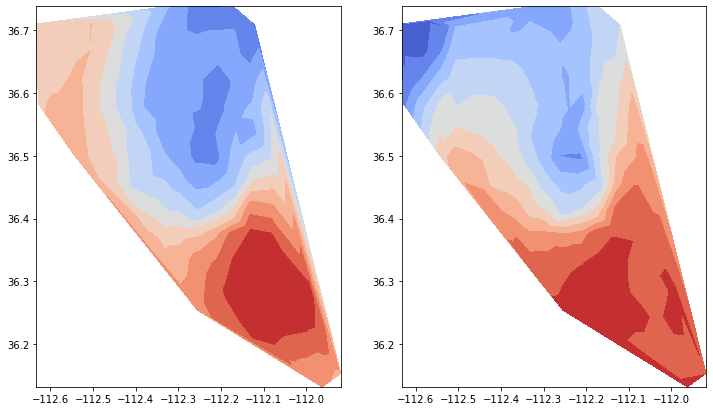

In [175]:
Sept2012_Monsoon = event(flow_regime = 'Monsoon', start_date = '2012-08-25',stop_date ='2012-09-15', eventname ='September 2013 Monsoon Event');
Sept2012_Monsoon.best_lag(plot_type='box')
Sept2012_Monsoon.contourmap(t_lag=0,d_lag=1,basemap=False)

### September 2013 Monsoon Event

In [176]:
# Sept2013_Monsoon = event(flow_regime = 'Monsoon', start_date = '2013-08-26',stop_date ='2013-09-06', eventname ='September 2013 Monsoon Event');
# Sept2013_Monsoon.best_lag(plot_type='box')
# Sept2013_Monsoon.contourmap(t_lag=0,d_lag=0,basemap=False)

### June 2015 Monsoon Event

In [177]:
June2015_M = event('Monsoon', '2015-06-01', '2015-06-30', 'June 2015 Monsoon Event')

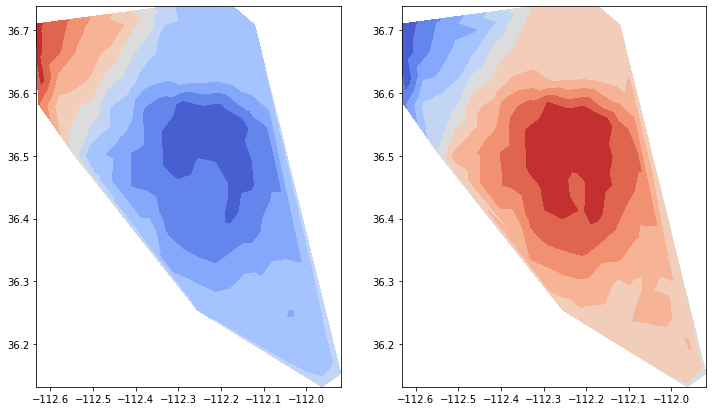

In [178]:
June2015_M.best_lag('box')
June2015_M.contourmap(t_lag=6, d_lag=2, basemap=False)

### October 2015 Monsoon Event

In [179]:
Oct2015_M = event('Monsoon', '2015-10-11', '2015-11-01','October 2015 Monsoon Event')

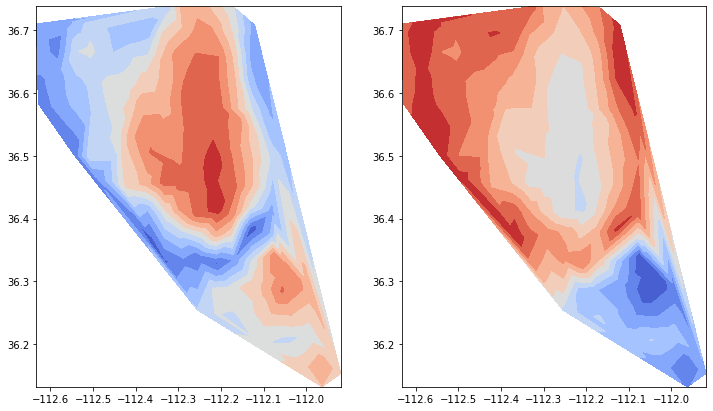

In [180]:
Oct2015_M.best_lag('box')
Oct2015_M.contourmap(6,4, basemap=False)

### February 2019 Event

In [181]:
Feb2019_Monsoon = event(flow_regime = 'Monsoon', start_date = '2019-02-08',stop_date ='2019-02-20', eventname ='February Snowmelt/Monsoon Event');
Feb2019_Monsoon.best_lag(plot_type='box')
Feb2019_Monsoon.contourmap(t_lag=2,d_lag=1,basemap=True)

C:\Users\Nick\anaconda3\lib\site-packages\numpy\lib\function_base.py:2526: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Nick\anaconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning:

divide by zero encountered in true_divide



NameError: name 'fl' is not defined

## Snowmelt Events

### Complete seasons of snowmelt

#### 2012 Snowmelt

In [ ]:
# Year2012_S = event('Snowmelt','2012-03-02', '2012-05-8', '2012 Snowmelt')
# Year2012_S.best_lag('box')
# Year2012_S.contourmap(2,1,basemap=False)

#### 2013 Snowmelt 

In [ ]:
# Year2013_S = event('Snowmelt','2013-03-12', '2013-04-16', '2013 Snowmelt')
# Year2013_S.best_lag('box')
# Year2013_S.contourmap(7,6,basemap=False)

#### 2015 Snowmelt

In [ ]:
#Not a significant event

#Year2015_S = event('Snowmelt','2015-03-15', '2015-04-18', '2015 Snowmelt')
#Year2015_S.best_lag('box')
#Year2015_S.contourmap(8,2,basemap=False)

#### 2016 Snowmelt

In [ ]:
# Year2016_S = event('Snowmelt','2016-02-24', '2016-03-30', '2016 Snowmelt')
# Year2016_S.best_lag('box')
# Year2016_S.contourmap(6,2,basemap=False)

#### 2017 Snowmelt

In [ ]:
Year2017_S = event('Snowmelt','2017-03-15', '2017-04-29', '2017 Snowmelt')
Year2017_S.best_lag('box')
Year2017_S.contourmap(7,3,basemap=False)

#### 2019 Snowmelt

In [ ]:
Year2019_S = event('Snowmelt','2019-04-23', '2019-05-27', '2019 Snowmelt')
Year2019_S.best_lag('box')
Year2019_S.contourmap(1,2,basemap=False)

### Breaking down of specific snowmelt events during each seasons

In [ ]:
March2017_S = event('Snowmelt','2017-03-08', '2017-03-28', 'March 2017 Snowmelt')
March2017_S.best_lag('box')
March2017_S.contourmap(6,5,basemap=False)

In [ ]:
April2017_S = event('Snowmelt','2017-04-06', '2017-05-03', '2017 Snowmelt')
April2017_S.best_lag('box')
April2017_S.contourmap(3,2,basemap=False)

In [ ]:
April2019_S = event('Snowmelt','2019-04-03', '2019-04-14', 'April 2019 Snowmelt')
April2019_S.best_lag('box')
April2019_S.contourmap(4,2,basemap=False)

In [ ]:
#### Weird 2019 Precip/Snowmelt combo event (rain on snow?)

In [ ]:
# SP_Event = event('Monsoon','2019-02-01', '2019-02-10', '2019 Snow/Precip Event')
# SP_Event.best_lag('box')
# SP_Event.contourmap(7,3,basemap=False)

In [ ]:
# SP_Event2 = event('Snowmelt','2019-02-13', '2019-02-24', '2019 Snow/Precip Event')
# SP_Event2.best_lag('box')
# SP_Event2.contourmap(7,3,basemap=False)

# 4.0 Descriptive Statistics of Roaring Springs

### 4.1 Mean and Variance of RS Shallow Site Depth and Deep Site Discharge

In [228]:
RS_shallow.describe()

,Pressure(psi),Temp(degC),Depth(ft)
count,265140.000000,265141.000000,265142.000000
mean,0.335120,10.756475,0.712410
std,0.225532,0.431136,0.499672
min,0.225000,8.725000,0.481317
25%,0.248000,10.727000,0.553494
50%,0.261000,10.905000,0.581000
75%,0.334538,10.999039,0.617000
max,1.824829,11.096390,3.992283


In [229]:
RS_deep.describe()

,Discharge ft^3/s
count,172880.000000
mean,8.966583
std,9.292260
min,5.212342
25%,5.673731
50%,5.997072
75%,6.973632
max,71.179589


In [230]:
RS_deep.head()

,Datetime,Discharge ft^3/s
Datetime,,
2015-02-07 13:00:00,2015-02-07 13:00:00,5.764846
2015-02-07 13:15:00,2015-02-07 13:15:00,5.759566
2015-02-07 13:30:00,2015-02-07 13:30:00,5.774497
2015-02-07 13:45:00,2015-02-07 13:45:00,5.643982
2015-02-07 14:00:00,2015-02-07 14:00:00,5.656094


In [231]:
RS_deep.max()

Datetime            2020-01-15 00:06:00
Discharge ft^3/s                71.1796
dtype: object

{'bodies': [<matplotlib.collections.PolyCollection at 0x2530ca741c8>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x2530ca74ac8>,
 'cmins': <matplotlib.collections.LineCollection at 0x2530a369988>,
 'cbars': <matplotlib.collections.LineCollection at 0x2530ca74108>}

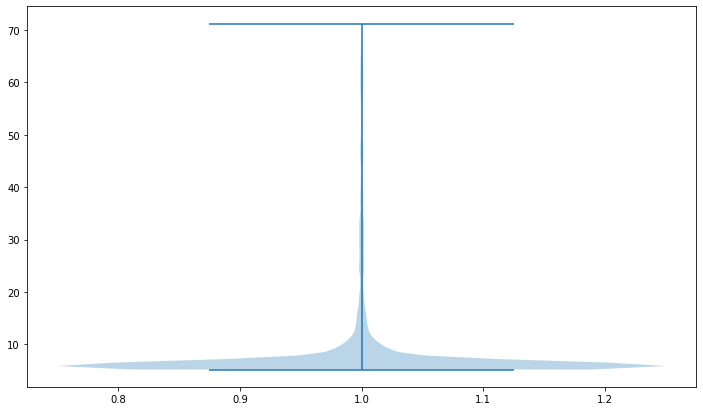

In [232]:
plt.violinplot(RS_deep['Discharge ft^3/s'])

### 4.1.2: Correlation heatmap and sns pair plot between the different variables (KP means and RS)

In [233]:
import seaborn as sns

In [234]:
# PRISM_KPmean_precip
# PRISM_KPmean_temp
# MODIS_KPmean_EVT
# RS_Deep
#RS_deep = pd.merge(RS_deep_raw,RS_deep)


In [235]:
print(PRISM_KPmean_precip.shape)
print(PRISM_KPmean_temp.shape)
print(MODIS_KPmean_EVT.shape)
print(RS_shallow_daily.shape)

(2769, 2)
(2769, 2)
(351, 2)
(2763, 3)


In [236]:
MODIS_KPmean_EVT.head()

,system:time_start,ET
0,2012-01-01,25.743
1,2012-01-09,31.535
2,2012-01-17,43.141
3,2012-01-25,31.149
4,2012-02-02,55.052


In [237]:
RS_shaldaily= RS_shallow_daily.reset_index()
RS_shaldaily.head()

,Datetime,Pressure(psi),Temp(degC),Depth(ft)
0,2012-02-21,0.256646,10.685833,0.592542
1,2012-02-22,0.256240,10.686865,0.591771
2,2012-02-23,0.257531,10.689417,0.594552
3,2012-02-24,0.257542,10.690240,0.594719
4,2012-02-25,0.257115,10.690417,0.593677


In [238]:
KP_Variables = pd.merge(PRISM_KPmean_precip,PRISM_KPmean_temp)
KP_Variables.head()

,system:time_start,ppt,tmean
0,2012-01-01,0.0,5.127
1,2012-01-02,0.0,5.523
2,2012-01-03,0.0,5.393
3,2012-01-04,0.0,6.671
4,2012-01-05,0.0,6.415


In [239]:
Most_Variables = pd.merge(KP_Variables,RS_shallow_daily, left_on='system:time_start',right_on="Datetime")

In [240]:
Most_Variables.head(4)

,system:time_start,ppt,tmean,Pressure(psi),Temp(degC),Depth(ft)
0,2012-02-21,0.0,-0.212,0.256646,10.685833,0.592542
1,2012-02-22,0.0,4.600,0.256240,10.686865,0.591771
2,2012-02-23,0.0,7.432,0.257531,10.689417,0.594552
3,2012-02-24,0.0,3.951,0.257542,10.690240,0.594719


In [241]:
All_Variables = pd.merge(Most_Variables, MODIS_KPmean_EVT, left_on='system:time_start', right_on='system:time_start')

In [242]:
All_Variables.head(10)  #noticed that since ET is every 8 days, it removed the data from the other variables...good for now though I guess

,system:time_start,ppt,tmean,Pressure(psi),Temp(degC),Depth(ft),ET
0,2012-02-26,0.000,4.846,0.259177,10.691865,0.598406,59.363
1,2012-03-05,0.000,6.711,0.256031,10.697604,0.591167,30.436
2,2012-03-13,0.000,8.672,0.264667,10.695802,0.611021,44.239
3,2012-03-21,0.000,1.344,0.277406,10.661344,0.640594,29.520
4,2012-03-29,0.000,9.557,0.417687,10.446260,0.964542,35.825
5,2012-04-06,0.000,8.774,0.482552,9.979240,1.114229,34.925
6,2012-04-14,3.999,3.301,0.428375,9.913792,0.989094,60.179
7,2012-04-22,0.000,16.748,0.553844,9.811792,1.278813,49.187
8,2012-04-30,0.000,11.486,0.396771,9.931750,0.916021,54.155
9,2012-05-08,0.000,11.346,0.324240,10.195333,0.748625,61.994


In [243]:
All_Variables.dropna(inplace=True)

In [244]:
import matplotlib as plt

In [245]:
Most_Variables.

SyntaxError: invalid syntax (<ipython-input-245-9270336b8deb>, line 1)

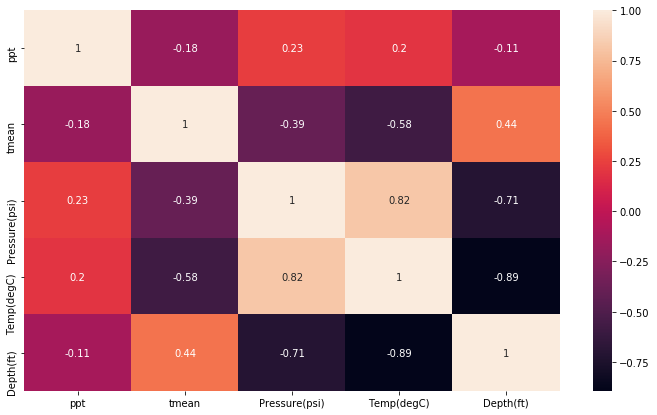

In [246]:
#  temp_timefilter = [mf_t_noNA[i][(mf_t_noNA[i].Date >= self.start_date) & (mf_t_noNA[i].Date <= self.stop_date)] for i in list(range(0,136))]
# plt.figure(figsize=(16,9))

date1 = '2017-10-15'
date2 = '2018-03-15'
sns.heatmap(Most_Variables[(Most_Variables['system:time_start'] >= date1) & (Most_Variables['system:time_start'] <= date2)].corr(), annot=True);

### 4.2 Seasonal Decomposition of the dataset

In [247]:
#Will likely need to separate out baseflow before really being able to seasonally decompose the time-series
#and extract a valid trend.  This works for now though.

In [248]:
#RS_shallow.reset_index(inplace=True)
RS_shallow.head(2)

,Datetime,Pressure(psi),Temp(degC),Depth(ft)
Datetime,,,,
2012-02-21 12:00:00,2012-02-21 12:00:00,0.256,10.688,0.590
2012-02-21 12:15:00,2012-02-21 12:15:00,0.258,10.686,0.595


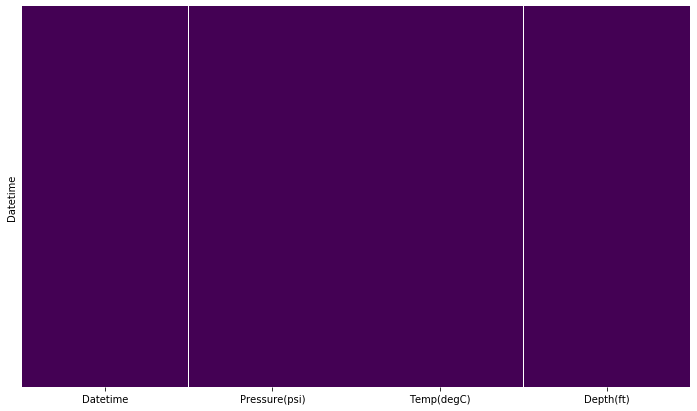

In [249]:
#Check to see if there are any null values in data by plotting a heatmap of the dataset.
sns.heatmap(RS_shallow.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [250]:
#Heatmap doesn't show really any missing values, but seasonal decomposition won't accept any whatsoever, so let's run the command to drop NA's just in case.
RS_shallow.dropna(inplace=True)
RS_shallow.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265139 entries, 2012-02-21 12:00:00 to 2019-09-14 12:00:00
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Datetime       265139 non-null  datetime64[ns]
 1   Pressure(psi)  265139 non-null  float64       
 2   Temp(degC)     265139 non-null  float64       
 3   Depth(ft)      265139 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 10.1 MB


In [251]:
RS_shallow.shape #this is the shape of the array: 4 columns with 265180 entries/rows/15min datapoints

(265139, 4)

C:\Users\Nick\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



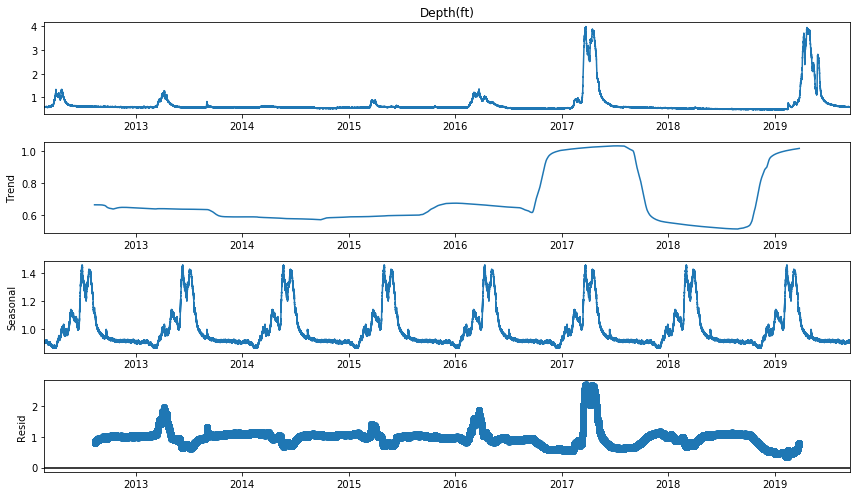

In [252]:
from statsmodels.tsa.seasonal import seasonal_decompose

d=seasonal_decompose(RS_shallow['Depth(ft)'], model='multiplicative', freq=33147)  
# to infer the frequency value, since total of 265139 measurements were collected, 
#265139/~8 years = freq of 33147 measurements/cycle
trend = pd.DataFrame(d.trend)
seasonality = pd.DataFrame(d.seasonal)
#d.trend.plot(figsize=(12,4), title="Trend",grid=True)
#d.seasonal.plot(figsize=(12,4), grid=True)
d.plot(); #put a semi colon here or else it will diplicate the plot for some reason.

#sns.lmplot(x=trend.iloc['Datetime'], y = 'Depth(ft)', data=trend)
#plt.savefig(fname='prediction_trend')

### 4.2 Tests for stationarity: Dickey-Fuller Test.  Stationary = var, mean, autocorr do not change over time.

In [253]:
from statsmodels.tsa.stattools import adfuller

In [254]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")


In [255]:
adfuller(RS_shallow_daily['Depth(ft)'])

dftest = adfuller(RS_shallow_daily['Depth(ft)'])
dfout = pd.Series(dftest[0:4], index=['ADF Test Statistics', 'p-value', '# Lags Used', '#Observations'])

for key, val in dftest[4].items():
    dfout[f'critical value ({key})'] = val

dfout


ADF Test Statistics    -5.850339e+00
p-value                 3.601748e-07
# Lags Used             2.600000e+01
#Observations           2.736000e+03
critical value (1%)    -3.432742e+00
critical value (5%)    -2.862597e+00
critical value (10%)   -2.567333e+00
dtype: float64

In [256]:
adf_test(RS_shallow_daily['Depth(ft)'])
#Shows RS has not seen any changes to depth/discharge since the shallow site has been recording. 

Augmented Dickey-Fuller Test: 
ADF test statistic     -5.850339e+00
p-value                 3.601748e-07
# lags used             2.600000e+01
# observations          2.736000e+03
critical value (1%)    -3.432742e+00
critical value (5%)    -2.862597e+00
critical value (10%)   -2.567333e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [257]:
adf_test(RS_shallow['Temp(degC)'])
#Shows RS has not seen any changes to temperature since the shallow site has been recording. 

Augmented Dickey-Fuller Test: 
ADF test statistic          -4.726793
p-value                      0.000075
# lags used                 87.000000
# observations          265051.000000
critical value (1%)         -3.430375
critical value (5%)         -2.861551
critical value (10%)        -2.566776
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [258]:
adf_test(RS_deep['Discharge ft^3/s'])
#Shows RS has not seen any changes to discharge since the deep site has been recording. 

Augmented Dickey-Fuller Test: 
ADF test statistic          -3.685557
p-value                      0.004321
# lags used                 78.000000
# observations          172801.000000
critical value (1%)         -3.430388
critical value (5%)         -2.861557
critical value (10%)        -2.566779
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [259]:
adf_test(Target_Predictors['tmean'])

NameError: name 'Target_Predictors' is not defined

In [ ]:
adf_test(Target_Predictors['precipitation'])

### 4.3 Seasonality Plots

In [260]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot,seasonal_plot

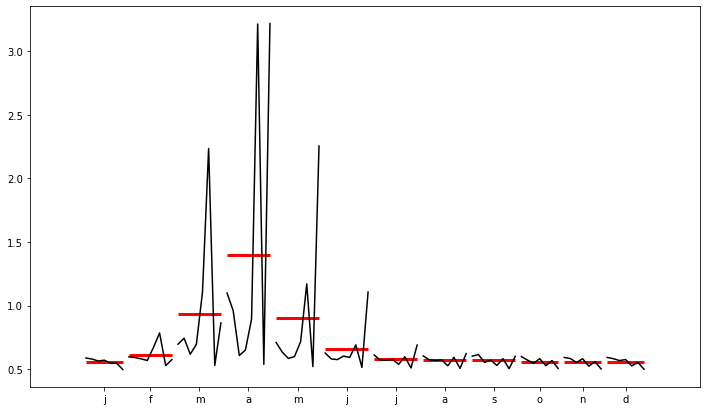

In [261]:
month_plot(RS_shallow['Depth(ft)'].resample(rule='MS').mean());

In [ ]:
#filter out and count number of precipitation events that occur as rain (i.e. count number of events when surface temps are greater than 0+ deg C, or between summer months)

# 5.0 Precipitation Response Modelling 
## First attempt is via a SARIMAX Model

### 5.1 Perform Grangercausality tests to assess variables to be used in forecasting

In [268]:
from statsmodels.tsa.stattools import grangercausalitytests

In [ ]:
RS_shallow_daily.head() #changed RS_s to RS_shallow_daily

#### Import predictor variable datasets

In [262]:
KPprecip = pd.read_csv('KP_mean_precip.csv', index_col=0,parse_dates=True)
KPprecip.index.freq = 'D'

In [263]:
KPtemp = pd.read_csv('PRISM_KPmean_temp.csv', index_col=0,parse_dates=True)
KPtemp.index.freq = 'D'

In [ ]:
# KPevt = pd.read_csv('KP_mean_EVT.csv', index_col=0,parse_dates=True)
# KPevt.index.freq = 'D'

#### Merge target and predictor variables all in one dataframe:

In [264]:
Target_Predictors0 = RS_shallow_daily.join(KPprecip, how='outer')
Target_Predictors = Target_Predictors0.join(KPtemp, how='outer')
Target_Predictors.sample(15)

,Pressure(psi),Temp(degC),Depth(ft),precipitation,tmean
2013-10-20,0.245698,10.858010,0.567354,0.0,9.560
2014-08-07,0.245812,10.964781,0.569927,0.0,20.178
2015-11-04,0.253406,11.011281,0.590396,0.0,4.073
2019-06-14,0.525862,9.864049,0.953998,NaN,21.624
2018-04-15,0.342024,10.974287,0.529524,0.0,7.408
2016-11-22,0.237135,11.028260,0.527387,0.0,3.479
2013-06-14,0.251781,10.743042,0.581281,0.0,21.574
2016-04-18,0.386156,10.297698,0.897031,0.0,5.033
2013-08-21,0.245135,10.846260,0.566083,0.0,22.529
2018-02-17,0.339694,10.973394,0.524143,0.0,0.608


#### Find nulls in new dataframe and remove them

In [ ]:
sns.heatmap(Target_Predictors.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [265]:
Target_Predictors.dropna(inplace=True)
Target_Predictors.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2505 entries, 2012-02-21 to 2018-12-30
Freq: D
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pressure(psi)  2505 non-null   float64
 1   Temp(degC)     2505 non-null   float64
 2   Depth(ft)      2505 non-null   float64
 3   precipitation  2505 non-null   float64
 4   tmean          2505 non-null   float64
dtypes: float64(5)
memory usage: 117.4 KB


#### Plot to figure out what indices to run causality tests on

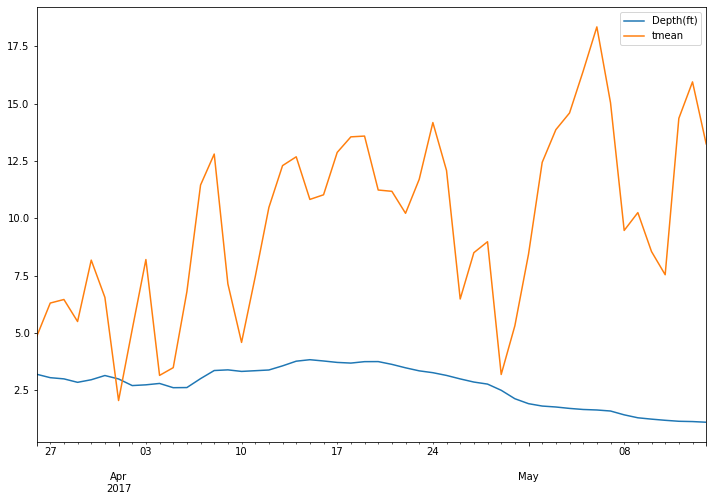

In [266]:
Target_Predictors[['Depth(ft)', 'tmean']][1860:1910].plot(figsize=(12,8))

#### Run several causality tests to see which variables at what time intervals show the best causality

In [269]:
grangercausalitytests(Target_Predictors[['precipitation','Depth(ft)']], maxlag=10);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0754  , p=0.7836  , df_denom=2501, df_num=1
ssr based chi2 test:   chi2=0.0755  , p=0.7834  , df=1
likelihood ratio test: chi2=0.0755  , p=0.7835  , df=1
parameter F test:         F=0.0754  , p=0.7836  , df_denom=2501, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0559  , p=0.9456  , df_denom=2498, df_num=2
ssr based chi2 test:   chi2=0.1121  , p=0.9455  , df=2
likelihood ratio test: chi2=0.1121  , p=0.9455  , df=2
parameter F test:         F=0.0559  , p=0.9456  , df_denom=2498, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7553  , p=0.5192  , df_denom=2495, df_num=3
ssr based chi2 test:   chi2=2.2723  , p=0.5178  , df=3
likelihood ratio test: chi2=2.2713  , p=0.5180  , df=3
parameter F test:         F=0.7553  , p=0.5192  , df_denom=2495, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8832  , p=0.

In [270]:
grangercausalitytests(Target_Predictors[['tmean','Depth(ft)']][1860:1910], maxlag=10);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5747  , p=0.2159  , df_denom=46, df_num=1
ssr based chi2 test:   chi2=1.6774  , p=0.1953  , df=1
likelihood ratio test: chi2=1.6494  , p=0.1990  , df=1
parameter F test:         F=1.5747  , p=0.2159  , df_denom=46, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6487  , p=0.0823  , df_denom=43, df_num=2
ssr based chi2 test:   chi2=5.9134  , p=0.0520  , df=2
likelihood ratio test: chi2=5.5766  , p=0.0615  , df=2
parameter F test:         F=2.6487  , p=0.0823  , df_denom=43, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8367  , p=0.4817  , df_denom=40, df_num=3
ssr based chi2 test:   chi2=2.9494  , p=0.3995  , df=3
likelihood ratio test: chi2=2.8606  , p=0.4136  , df=3
parameter F test:         F=0.8367  , p=0.4817  , df_denom=40, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9136  , p=0.4663  , df_d

In [271]:
GCT = pd.DataFrame(grangercausalitytests(Target_Predictors[['tmean','Temp(degC)']][1860:1910], maxlag=10));


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3949  , p=0.5328  , df_denom=46, df_num=1
ssr based chi2 test:   chi2=0.4207  , p=0.5166  , df=1
likelihood ratio test: chi2=0.4189  , p=0.5175  , df=1
parameter F test:         F=0.3949  , p=0.5328  , df_denom=46, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3122  , p=0.7335  , df_denom=43, df_num=2
ssr based chi2 test:   chi2=0.6969  , p=0.7058  , df=2
likelihood ratio test: chi2=0.6919  , p=0.7075  , df=2
parameter F test:         F=0.3122  , p=0.7335  , df_denom=43, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6263  , p=0.6022  , df_denom=40, df_num=3
ssr based chi2 test:   chi2=2.2077  , p=0.5304  , df=3
likelihood ratio test: chi2=2.1574  , p=0.5404  , df=3
parameter F test:         F=0.6263  , p=0.6022  , df_denom=40, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2098  , p=0.3231  , df_d

In [272]:
GCT[2][0]['ssr_ftest']


(0.3121657454050501, 0.7335047354520772, 43.0, 2)

### 5.2 Perform Auto-Arima/grid search to determine what values for order and seasonal order of arima are best.

In [ ]:
len(Target_Predictors['Depth(ft)'])

In [ ]:
train = Target_Predictors.iloc[:2500]

In [ ]:
test = Target_Predictors.iloc[2501:]

In [ ]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [ ]:
len(RS_shallow_daily)

In [ ]:
len(RS_shallow_daily)/345

In [ ]:
autoarima = auto_arima(RS_shallow_daily['Depth(ft)'],approx=False, trace=True,seasonal=True,m=1, start_p=0, start_q=0, max_p=5, max_q=3)


In [ ]:
autoarima.summary()
#Shows results of best fitting model

In [ ]:
#help(auto_arima)

### 5.3 Use ACF and PACF to check auto_arima values for the order and seasonal order parameters.

In [ ]:
import statsmodels.api as sm

In [ ]:
from statsmodels.tsa.stattools import acovf, pacf, pacf_yw, pacf_ols

In [ ]:
from pandas.plotting import lag_plot

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
plot_acf(RS_shallow_daily['Depth(ft)'], lags = 25);

In [ ]:
plot_pacf(RS_shallow_daily['Depth(ft)'], lags = 25);

### 5.4 Run and fit SARIMAX model without exogenous variables (precip and temp on Kaibab Plateau)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
len(Target_Predictors['Depth(ft)'])

In [ ]:
train = Target_Predictors.iloc[:2000]
test = Target_Predictors.iloc[2001:]

In [ ]:
#from auto_arima results, model that should be used is: SARIMAX(3, 1, 3)
model = SARIMAX(train['Depth(ft)'], order = (3,1,3), enforce_invertibility=False)

In [ ]:
results=model.fit()

In [ ]:
results.summary()

In [ ]:
start = len(train)
end = len(train) + len(test) - 1

In [ ]:
predictions = results.predict(start,end).rename('SARIMA Model')

In [ ]:
train['Depth(ft)'][1000:].rename('Training Depth (ft)').plot(legend=True,figsize=(15,8))
test['Depth(ft)'].rename('Test Depth (ft)').plot(legend=True)
predictions.rename('SARIMA Modelled Depth (ft)').plot(legend=True)

In [ ]:
from statsmodels.tools.eval_measures import rmse

In [ ]:
rmse(test['Depth(ft)'], predictions)    

## Putting the X in SARIMAX

In [ ]:
PRISM_KPmean_precip = pd.read_csv('PRISM_KPmean_precip.csv',index_col='system:time_start', parse_dates=True)

### Train and test autoarima with exogenous variable.  Not forecasting yet.

In [ ]:
Target_Predictors.head()

In [ ]:
print(Target_Predictors['Depth(ft)'].shape)
print(Target_Predictors['precipitation'].shape)
print(Target_Predictors['tmean'].shape)

In [ ]:
exog = Target_Predictors[['precipitation','tmean']]
#These variables need to be filtered.  Precipitation should only be an exog variable in summer months as it's stored as 
#snowpack during winter months and is not a good direct predictor. Observing plot of discharge vs. surface temps, surface 
#temps are a clear a trigger for snowmelt events in winter/spring runoff, but are meaningless in the summer.  

In [ ]:
AAx = auto_arima(y=Target_Predictors['Depth(ft)'], trace=True, start_p=0, start_q=0, max_p=5, max_q=3, 
                 m=1, seasonal=True) 
AAx.summary()

#### Fit model to training data

In [ ]:
model = SARIMAX(train['Depth(ft)'], exog = exog.iloc[:2000], seasonal=True, m=1, order = (3,1,3), enforce_invertibility=False, enforce_stationarity=False)

#need double [[]] for exog variable

In [ ]:
result = model.fit()

In [ ]:
result.summary()

In [ ]:
start = len(train)
end = len(train) + len(test) - 1

In [ ]:
predictions = result.predict(start,end,exog=exog.iloc[2001:]).rename('SARIMAX with Exog')

In [ ]:
train['Depth(ft)'][1000:].rename('Training Depth (ft)').plot(legend=True,figsize=(15,8))
test['Depth(ft)'].rename('Test Depth (ft)').plot(legend=True)
predictions.rename('Modelled SARIMAX Depth (ft)').plot(legend=True)

In [ ]:
rmse(test['Depth(ft)'],predictions)